In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
data = pd.read_csv('../artifacts/sentiment_analysis.csv')

In [29]:
data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


## Data Preprocessing

In [30]:
data.shape

(7920, 3)

In [31]:
data.duplicated().sum()

np.int64(0)

In [32]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

### Text Preprocessing

In [33]:
import re
import string

 convert uppercase to lowercase

In [35]:
data["tweet"] = data["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [36]:
data["tweet"].head(5)

0    #fingerprint #pregnancy test https://goo.gl/h1...
1    finally a transparant silicon case ^^ thanks t...
2    we love this! would you go? #talk #makememorie...
3    i'm wired i know i'm george i was made that wa...
4    what amazing service! apple won't even talk to...
Name: tweet, dtype: object

Remove Links

In [38]:
data["tweet"] = data["tweet"].apply(lambda x: " ".join(re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE) for x in x.split()))

In [39]:
data["tweet"].head(5)

0    #fingerprint #pregnancy test  #android #apps #...
1    finally a transparant silicon case ^^ thanks t...
2    we love this! would you go? #talk #makememorie...
3    i'm wired i know i'm george i was made that wa...
4    what amazing service! apple won't even talk to...
Name: tweet, dtype: object

remove punctuations

In [43]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation,'')
    return text

data["tweet"] = data["tweet"].apply(remove_punctuations)

In [44]:
data["tweet"].head(5)

0    fingerprint pregnancy test  android apps beaut...
1    finally a transparant silicon case  thanks to ...
2    we love this would you go talk makememories un...
3    im wired i know im george i was made that way ...
4    what amazing service apple wont even talk to m...
Name: tweet, dtype: object

Remove Numbers

In [45]:
data["tweet"] = data["tweet"].str.replace('\d+','',regex=True)

In [47]:
data["tweet"].tail(5)

7915    live out loud lol liveoutloud selfie smile son...
7916    we would like to wish you an amazing day make ...
7917    helping my lovely  year old neighbor with her ...
7918    finally got my smart pocket wifi stay connecte...
7919    apple barcelona apple store bcn barcelona trav...
Name: tweet, dtype: object

Remove StopWords

In [50]:
import nltk

In [51]:
nltk.download('stopwords', download_dir='../static/model')

[nltk_data] Downloading package stopwords to ../static/model...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [52]:
with open('../static/model/corpora/stopwords/english','r') as file:
    sw = file.read().splitlines()

In [2]:
#sw  #show the stop word list

In [55]:
data["tweet"] = data["tweet"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [56]:
data["tweet"].head()

0    fingerprint pregnancy test android apps beauti...
1    finally transparant silicon case thanks uncle ...
2    love would go talk makememories unplug relax i...
3    im wired know im george made way iphone cute d...
4    amazing service apple wont even talk question ...
Name: tweet, dtype: object

Stemming  (get the base word)

In [57]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [59]:
data["tweet"] = data["tweet"].apply(lambda x: " ".join(ps.stem(x) for x in x.split()))

In [ ]:
data["tweet"].head()

### Building Vocabulary

In [65]:
from collections import Counter
vocab = Counter()

In [68]:
for sentence in data['tweet']:
    vocab.update(sentence.split())
    #print(sentence)

In [1]:
#vocab

In [74]:
len(vocab)

15949

In [75]:
data.shape

(7920, 3)

In [79]:
tokens = [key for key in vocab if vocab[key] > 10]

In [80]:
len(tokens)

1145

In [81]:
def save_vocabulary(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()

save_vocabulary(tokens, '../static/model/vocabulary.txt')

### Divide dataset

In [ ]:
x = data['tweet']
y = data['label']

In [123]:
#pip install scikit-learn

In [92]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,  y_test = train_test_split(x, y, test_size=0.2)

In [100]:
y_train.shape

(6336,)

In [94]:
x_test.shape

(1584,)

# Vectorization

In [97]:
def vectorizer(ds, vocabulary):
    vectorized_lst = []

    for sentence in ds:
        sentence_lst = np.zeros(len(vocabulary))

        for i in range(len(vocabulary)):
            if vocabulary[i] in sentence.split():
                sentence_lst[i] = 1
        vectorized_lst.append(sentence_lst)
    vectorized_lst_new = np.array(vectorized_lst, dtype=np.float32)

    return vectorized_lst_new
    

In [113]:
vectorized_x_train = vectorizer(x_train, tokens)

In [114]:
vectorized_x_test = vectorizer(x_test, tokens)

In [116]:
vectorized_x_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(6336, 1145), dtype=float32)

In [117]:
y_train.value_counts()

label
0    4703
1    1633
Name: count, dtype: int64

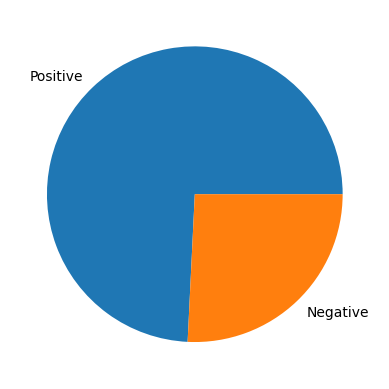

In [118]:
plt.pie(np.array([y_train.value_counts()[0], y_train.value_counts()[1]]),labels=['Positive', 'Negative'])
plt.show()

### Handle imblanced data

In [122]:
#pip install imbalanced-learn

In [119]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
vectorized_x_train_smote, y_train_smote = smote.fit_resample(vectorized_x_train, y_train)
print(vectorized_x_train_smote.shape, y_train_smote.shape)

(9406, 1145) (9406,)


In [121]:
y_train_smote.value_counts()

label
0    4703
1    4703
Name: count, dtype: int64

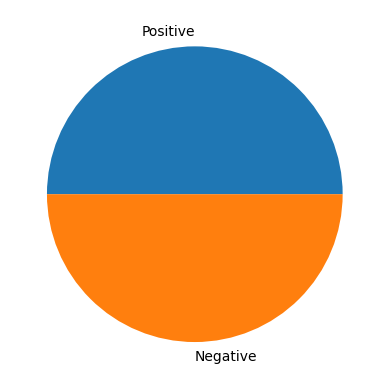

In [124]:
plt.pie(np.array([y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]]),labels=['Positive', 'Negative'])
plt.show()

In [126]:
vectorized_x_train_smote

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(9406, 1145), dtype=float32)

In [127]:
y_train_smote

0       0
1       0
2       0
3       1
4       0
       ..
9401    1
9402    1
9403    1
9404    1
9405    1
Name: label, Length: 9406, dtype: int64

In [130]:
vectorized_x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1584, 1145), dtype=float32)

In [131]:
y_test

263     0
5058    1
5669    0
1886    0
2030    0
       ..
6927    1
1658    0
3233    0
3045    0
7876    0
Name: label, Length: 1584, dtype: int64

## Model training and Evaluation

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [135]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 4)
    f1 = round(f1_score(y_act, y_pred), 4)
    rec = round(recall_score(y_act, y_pred), 4)
    pr = round(precision_score(y_act, y_pred), 4)
    print(f'Training Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 4)
    f1 = round(f1_score(y_act, y_pred), 4)
    rec = round(recall_score(y_act, y_pred), 4)
    pr = round(precision_score(y_act, y_pred), 4)
    print(f'Testing Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')


### Logistic Regression

In [146]:
lr = LogisticRegression()
lr.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = lr.predict(vectorized_x_train_smote)

training_scores(y_train_smote, y_train_pred)

y_test_pred = lr.predict(vectorized_x_test)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.9368
	Precision = 0.9121
	Recall = 0.9668
	F1-Score = 0.9387
Testing Scores:
	Accuracy = 0.8756
	Precision = 0.7094
	Recall = 0.8448
	F1-Score = 0.7712


In [139]:
y_train_pred

array([0, 0, 0, ..., 1, 1, 1], shape=(9406,))

### Naive Bayes

In [147]:
mnb = MultinomialNB()
mnb.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = mnb.predict(vectorized_x_train_smote)

training_scores(y_train_smote, y_train_pred)

y_test_pred = mnb.predict(vectorized_x_test)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.9058
	Precision = 0.8679
	Recall = 0.9573
	F1-Score = 0.9104
Testing Scores:
	Accuracy = 0.8699
	Precision = 0.6673
	Recall = 0.9491
	F1-Score = 0.7836


### Decision Tree

In [148]:
dt = DecisionTreeClassifier()
dt.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = dt.predict(vectorized_x_train_smote)

training_scores(y_train_smote, y_train_pred)

y_test_pred = dt.predict(vectorized_x_test)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.9997
	Precision = 1.0
	Recall = 0.9994
	F1-Score = 0.9997
Testing Scores:
	Accuracy = 0.8409
	Precision = 0.685
	Recall = 0.6641
	F1-Score = 0.6744


### Random Forest

In [150]:
rf = RandomForestClassifier()
rf.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = rf.predict(vectorized_x_train_smote)

training_scores(y_train_smote, y_train_pred)

y_test_pred = rf.predict(vectorized_x_test)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.9997
	Precision = 1.0
	Recall = 0.9994
	F1-Score = 0.9997
Testing Scores:
	Accuracy = 0.8737
	Precision = 0.7546
	Recall = 0.7277
	F1-Score = 0.7409


### Support Vector Machine

In [151]:
svm = SVC()
svm.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = svm.predict(vectorized_x_train_smote)

training_scores(y_train_smote, y_train_pred)

y_test_pred = svm.predict(vectorized_x_test)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.9765
	Precision = 0.9594
	Recall = 0.9951
	F1-Score = 0.9769
Testing Scores:
	Accuracy = 0.8801
	Precision = 0.7344
	Recall = 0.8092
	F1-Score = 0.77


#### save and load models


In [153]:
import pickle

with open('../static/model/model.pickle', 'wb') as file:
    pickle.dump(lr, file)